# Data Augmentation with VAE and KDE in the Regression Framework

This notebook provides a step-by-step explanation of the data augmentation techniques in our regression framework, with a focus on the Variational Autoencoder (VAE) method using Kernel Density Estimation (KDE).

## Table of Contents
1. [Introduction to Data Augmentation](#intro)
2. [Understanding VAE with KDE](#vae-kde)
3. [Setting Up and Running with Data Augmentation](#setup)
4. [How VAE+KDE Works Under the Hood](#under-hood)
5. [Visualizing and Evaluating Augmentation Quality](#visualizing)
6. [Parameter Tuning and Best Practices](#tuning)

## 1. Introduction to Data Augmentation <a id="intro"></a>

Data augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing data. In regression tasks, data augmentation is especially useful when:

1. **Limited data:** When you have a small dataset, augmentation helps create more training examples
2. **Imbalanced target distribution:** When certain regions of the target variable have few samples
3. **Improving model robustness:** By exposing the model to more variations of the data

Our regression framework supports three main methods of data augmentation:

1. **Gaussian Noise:** Adds random noise to existing samples
2. **SMOTE:** Uses Synthetic Minority Over-sampling Technique to generate new samples by interpolating between existing ones
3. **VAE:** Variational Autoencoder-based generation with two approaches:
   - **Binning:** Divides the target range into bins and generates samples for each bin
   - **KDE:** Uses Kernel Density Estimation to generate samples with similar distributions

In this notebook, we'll focus specifically on the VAE with KDE approach, which is particularly powerful for regression tasks.

## 2. Understanding VAE with KDE <a id="vae-kde"></a>

### Variational Autoencoder (VAE)

A Variational Autoencoder is a deep learning architecture that consists of two main components:
- An **encoder** that compresses input data into a lower-dimensional latent space
- A **decoder** that reconstructs the original data from the latent representation

Unlike traditional autoencoders, VAEs introduce a probabilistic element by encoding data as probability distributions rather than fixed points. This allows for generating new, realistic samples by sampling from the latent space.

### Kernel Density Estimation (KDE)

KDE is a non-parametric way to estimate the probability density function of a random variable. It works by placing a kernel (typically a Gaussian) at each data point and then summing these kernels to create a smooth density estimate.

### How They Work Together

In our framework, VAE with KDE combines these techniques in a specialized way for regression tasks:

1. The target variable range is divided into regions based on percentiles or equal-width bins
2. KDE is used to model the distribution of samples within each region
3. The VAE learns to generate new samples that follow these distributions
4. Underrepresented regions can be specifically targeted for more augmentation

This approach ensures that the augmented data maintains the important relationships between features and the target variable, while also addressing imbalances in the target distribution.

Let's first import the necessary libraries and set up our environment:

In [2]:
# Import core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Configure visualization settings
#plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Set random seed for reproducibility
np.random.seed(42)

Load a sample dataset (California Housing) for demonstration:

In [3]:
# Load California Housing dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

# For demonstration purposes, let's use a smaller subset
df = df.sample(1000, random_state=42).reset_index(drop=True)

# Split into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Define target column name
target = 'target'

print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
df_train.head()

Training set shape: (800, 9)
Test set shape: (200, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
29,6.2028,35.0,6.326531,1.013605,1167.0,2.646259,33.72,-118.30,3.615
535,2.9063,52.0,6.590444,1.122867,1025.0,3.498294,37.73,-122.39,1.920
695,1.9722,28.0,5.212435,1.181347,738.0,3.823834,36.49,-121.48,2.107
557,2.6400,45.0,4.847495,1.058824,1304.0,2.840959,37.93,-122.34,1.121
836,3.2841,15.0,5.478846,1.032692,878.0,1.688462,33.71,-117.75,1.583


Let's examine the distribution of our target variable to see if we have any imbalance issues:

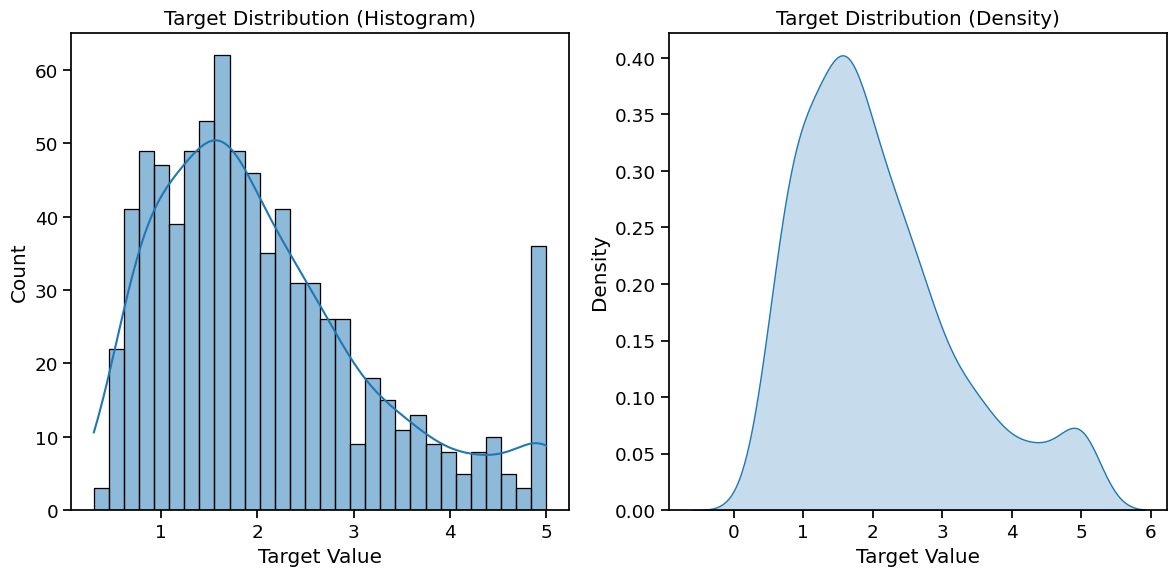

Target min: 0.30
Target max: 5.00
Target mean: 2.08
Target median: 1.82
Target std: 1.15

Target percentiles:


,Percentile,Value
0,0,0.30000
1,10,0.81480
2,20,1.07000
3,30,1.37500
4,40,1.58760
5,50,1.82400
6,60,2.12900
7,70,2.45000
8,80,2.89940
9,90,3.77080


In [4]:
# Plot distribution of target variable
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['target'], bins=30, kde=True)
plt.title('Target Distribution (Histogram)')
plt.xlabel('Target Value')

plt.subplot(1, 2, 2)
sns.kdeplot(df_train['target'], fill=True)
plt.title('Target Distribution (Density)')
plt.xlabel('Target Value')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Target min: {df_train['target'].min():.2f}")
print(f"Target max: {df_train['target'].max():.2f}")
print(f"Target mean: {df_train['target'].mean():.2f}")
print(f"Target median: {df_train['target'].median():.2f}")
print(f"Target std: {df_train['target'].std():.2f}")

# Calculate percentiles to identify potential regions
percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
percentile_values = np.percentile(df_train['target'], percentiles)
percentile_df = pd.DataFrame({
    'Percentile': percentiles,
    'Value': percentile_values
})
print("\nTarget percentiles:")
percentile_df

## 3. Setting Up and Running with Data Augmentation <a id="setup"></a>

Now let's see how to configure and run the regression framework with VAE+KDE data augmentation. The key is to set the appropriate parameters in the `RegressionBuilder` initialization:

In [6]:
import regression
# This is a demonstration of how to initialize the framework
# In a real scenario, you would import your regression module

# import regression  # In practice, you would import your module

# Example configuration for using VAE+KDE data augmentation

reg_train = regression.RegressionBuilder(
    input_training_df=df_train,                       # Training data DataFrame
    input_inference_df=None,                          # No inference data (training mode)
    target=target,                                    # Target column name
    hyperparameters_tune=True,                        # Enable hyperparameter tuning
    feature_selection_autoselect=True,                # Enable automatic feature selection
    model_choice=["randomforest"],                    # Use Random Forest regressor
    goal_metric="mse",                                # Optimize for mean squared error
    data_augmentation=True,                           # Enable data augmentation
    feature_selection_num=0,                          # Auto select features (0 = auto)
    saved_model=None,                                 # No pre-trained model
    saved_scaler=None,                                # No pre-fitted scaler
    data_augmentation_method="vae",                   # Use VAE for augmentation
    data_augmentation_sectioning="kde",               # Use KDE sectioning for VAE
    data_augmentation_region_num=20,                  # 20 regions for augmentation
    data_augmentation_min_samples_per_region=5,       # 5 samples minimum per region
    balance_strategy="increase",                      # Balance by increasing underrepresented regions
    k=5,                                              # Use 5-fold cross-validation
    sampling_method="random"                          # Use random sampling for train/test splits
).run_regression()


print("The configuration above shows how to initialize the framework with VAE+KDE data augmentation.")
print("Let's break down the key parameters related to data augmentation:")
print("\n1. data_augmentation=True - Enables the data augmentation process")
print("2. data_augmentation_method='vae' - Specifies using Variational Autoencoder")
print("3. data_augmentation_sectioning='kde' - Uses Kernel Density Estimation for sectioning")
print("4. data_augmentation_region_num=20 - Divides the target range into 20 regions")
print("5. data_augmentation_min_samples_per_region=5 - Ensures at least 5 samples per region")
print("6. balance_strategy='increase' - Increases samples in underrepresented regions")

NameError: name 'regression' is not defined

Let's visualize how the regions would be defined with KDE sectioning on our dataset:

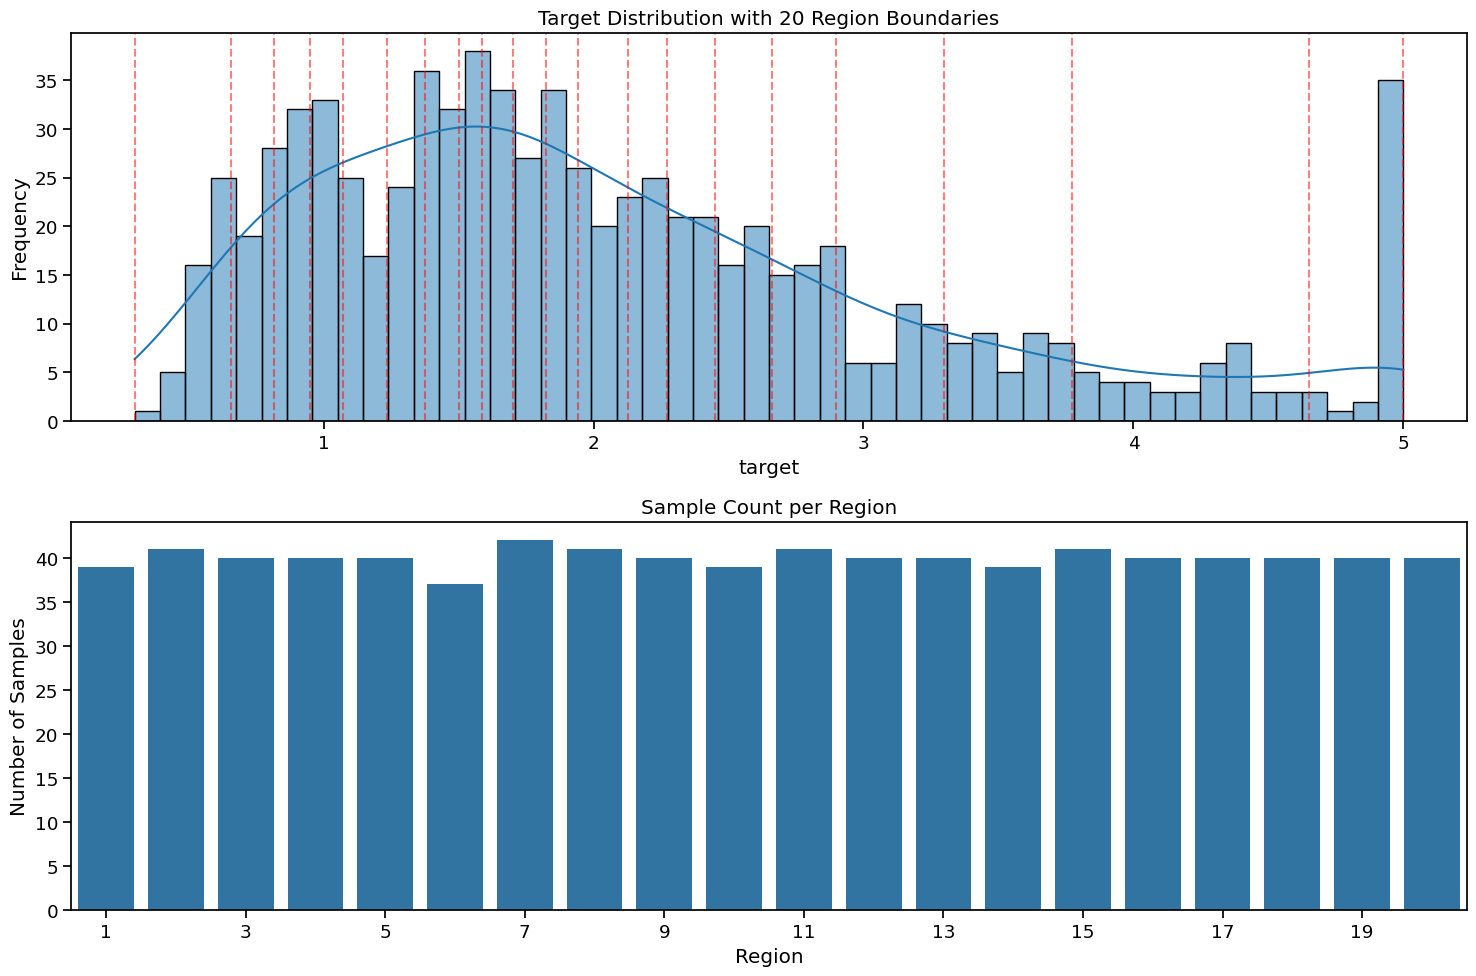

Minimum samples in a region: 37
Regions with few samples (20):


,Region,Min Value,Max Value,Count
0,1,0.30000,0.65800,39
1,2,0.65800,0.81480,41
2,3,0.81480,0.94970,40
3,4,0.94970,1.07000,40
4,5,1.07000,1.23375,40
5,6,1.23375,1.37500,37
6,7,1.37500,1.50300,42
7,8,1.50300,1.58760,41
8,9,1.58760,1.70010,40
9,10,1.70010,1.82400,39


In [7]:
# Function to visualize target regions for KDE sectioning
def visualize_kde_regions(data, target_col, num_regions=20):
    # Get target values
    target_values = data[target_col].values
    
    # Create region edges based on percentiles
    region_edges = np.percentile(target_values, np.linspace(0, 100, num_regions + 1))
    
    # Assign each sample to a region
    region_assignments = np.digitize(target_values, region_edges[1:-1])
    
    # Count samples per region
    region_counts = np.bincount(region_assignments, minlength=num_regions)
    
    # Create a DataFrame for plotting
    region_df = pd.DataFrame({
        'Region': range(1, num_regions + 1),
        'Min Value': region_edges[:-1],
        'Max Value': region_edges[1:],
        'Count': region_counts
    })
    
    # Plot the target distribution with regions
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Target distribution with region boundaries
    plt.subplot(2, 1, 1)
    sns.histplot(data[target_col], bins=50, kde=True)
    for edge in region_edges:
        plt.axvline(edge, color='red', linestyle='--', alpha=0.5)
    plt.title(f'Target Distribution with {num_regions} Region Boundaries')
    plt.xlabel(target_col)
    plt.ylabel('Frequency')
    
    # Plot 2: Sample count per region
    plt.subplot(2, 1, 2)
    sns.barplot(x='Region', y='Count', data=region_df)
    plt.title('Sample Count per Region')
    plt.xlabel('Region')
    plt.ylabel('Number of Samples')
    plt.xticks(range(0, num_regions, 2))
    
    plt.tight_layout()
    plt.show()
    
    # Identify underrepresented regions
    min_count = region_df['Count'].min()
    underrep_regions = region_df[region_df['Count'] <= min_count * 1.5]
    
    print(f"Minimum samples in a region: {min_count}")
    print(f"Regions with few samples ({len(underrep_regions)}):")    
    return region_df, region_assignments

# Visualize regions for our dataset
region_df, region_assignments = visualize_kde_regions(df_train, target, num_regions=20)
display(region_df.head(20))

## 4. How VAE+KDE Works Under the Hood <a id="under-hood"></a>

Now let's explore how the VAE+KDE data augmentation works step by step within the regression framework:

### 4.1 The VAE+KDE Process Flow

1. **Target Region Identification**:
   - The target variable range is divided into regions (by default, using percentiles)
   - Each data point is assigned to a region based on its target value
   - Regions with fewer samples than `data_augmentation_min_samples_per_region` are identified as underrepresented

2. **Kernel Density Estimation**:
   - KDE is applied to model the distribution of target values within each region
   - This provides a smooth probability density function for generating new target values
   - The bandwidth parameter controls the smoothness of the density estimate

3. **VAE Training**:
   - A Variational Autoencoder is trained on the training data
   - The encoder compresses the feature data into a latent space
   - The decoder learns to reconstruct the original features from the latent representation
   - The VAE is trained separately for each region to capture region-specific patterns

4. **Sample Generation**:
   - For each region, new target values are sampled from the KDE model
   - The corresponding feature values are generated using the trained VAE
   - The number of synthetic samples generated depends on the `balance_strategy` and region counts
   - With `balance_strategy="increase"`, more samples are generated for underrepresented regions

5. **Combined Dataset Creation**:
   - Original and synthetic samples are combined into a single augmented dataset
   - Each sample is marked with an `is_organic` flag (True for original, False for synthetic)
   - This combined dataset is then used for model training

### 4.2 Pseudocode for VAE+KDE Implementation

Here's a simplified pseudocode representation of the VAE+KDE augmentation process used in the framework:

In [ ]:
# This is pseudocode to illustrate the VAE+KDE process
'''
function data_augment_vae_kde(df_train, target_column, bin_edges, num_bins, balance_strategy, 
                            augmented_bucket_size, region_assignments):
    
    # 1. Identify regions and assignments
    if region_assignments is None:
        region_assignments = np.digitize(df_train[target_column], bin_edges[1:-1])
    
    # 2. Count samples per region
    region_counts = np.bincount(region_assignments, minlength=num_bins)
    
    # 3. Determine number of samples to generate per region
    if balance_strategy == "equal":
        # Make all regions have the same number of samples
        target_count = max(max(region_counts), augmented_bucket_size)
        samples_to_add = [max(0, target_count - count) for count in region_counts]
        
    elif balance_strategy == "increase":
        # Increase sample count in underrepresented regions
        median_count = np.median(region_counts)
        samples_to_add = [max(0, median_count - count) + augmented_bucket_size 
                          if count < median_count else augmented_bucket_size 
                          for count in region_counts]
    
    # 4. Initialize KDE for target generation
    target_values = df_train[target_column].values
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(target_values.reshape(-1, 1))
    
    # 5. Set up VAE architecture
    feature_dim = len(df_train.columns) - 1  # Exclude target column
    latent_dim = min(feature_dim, 10)  # Latent dimension, typically smaller than input
    vae = build_vae_model(feature_dim, latent_dim)
    
    # 6. Generate augmented samples for each region
    augmented_samples = []
    
    for region_idx in range(num_bins):
        # Get original samples for this region
        region_mask = (region_assignments == region_idx)
        region_samples = df_train[region_mask]
        
        if len(region_samples) == 0:
            continue
        
        # Get features (X) and target (y) for this region
        X_region = region_samples.drop(columns=[target_column])
        y_region = region_samples[target_column].values
        
        # Train VAE on this region's samples
        vae.fit(X_region, epochs=50, batch_size=32)
        
        # Fit KDE to region's target values
        region_kde = KernelDensity(kernel='gaussian').fit(y_region.reshape(-1, 1))
        
        # Generate new samples for this region
        num_samples = samples_to_add[region_idx]
        
        if num_samples > 0:
            # Generate new target values using KDE
            new_targets = region_kde.sample(num_samples).flatten()
            
            # Generate new features using VAE
            latent_samples = np.random.normal(0, 1, (num_samples, latent_dim))
            new_features = vae.decoder.predict(latent_samples)
            
            # Create new samples with generated features and targets
            for i in range(num_samples):
                new_sample = pd.Series(new_features[i], index=X_region.columns)
                new_sample[target_column] = new_targets[i]
                new_sample['is_organic'] = False
                augmented_samples.append(new_sample)
    
    # 7. Combine original and synthetic samples
    df_train_with_organic_flag = df_train.copy()
    df_train_with_organic_flag['is_organic'] = True
    
    augmented_df = pd.concat([df_train_with_organic_flag, 
                             pd.DataFrame(augmented_samples)], ignore_index=True)
    
    return augmented_df
'''

print("The pseudocode above illustrates the main steps in the VAE+KDE augmentation process.")

### 4.3 VAE+KDE Data Flow

Let's visualize the data flow in the VAE+KDE augmentation process:

In [9]:
# Let's create a visual representation of the VAE+KDE process
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import numpy as np

# Create a figure showing the VAE+KDE workflow
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors
colors = {
    'original': '#3498db',  # Blue
    'region': '#2ecc71',    # Green
    'kde': '#e74c3c',       # Red
    'vae': '#9b59b6',       # Purple
    'augmented': '#f39c12'  # Orange
}

# Set background color
ax.set_facecolor('#f9f9f9')

# Hide axes
ax.axis('off')

# Function to create boxes with text
def add_box(x, y, width, height, label, color, alpha=0.7):
    rect = Rectangle((x, y), width, height, facecolor=color, alpha=alpha, edgecolor='black', linewidth=1)
    ax.add_patch(rect)
    ax.text(x + width/2, y + height/2, label, ha='center', va='center', fontsize=12, fontweight='bold')
    return rect

# Function to create arrows
def add_arrow(start, end, label=None, color='black'):
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=20, color=color, linewidth=1.5)
    ax.add_patch(arrow)
    if label:
        mid_x = (start[0] + end[0]) / 2
        mid_y = (start[1] + end[1]) / 2
        ax.text(mid_x, mid_y, label, ha='center', va='center', fontsize=10, backgroundcolor='white')
    return arrow

# Create boxes for the workflow
original_data = add_box(1, 8, 3, 1, 'Original Data', colors['original'])
region_division = add_box(1, 6, 3, 1, 'Region Division', colors['region'])

# Region boxes
region_boxes = []
for i in range(3):
    label = f'Region {i+1}'
    box = add_box(1 + i*4, 4, 2, 1, label, colors['region'], alpha=0.5)
    region_boxes.append(box)

# KDE boxes
kde_boxes = []
for i in range(3):
    label = 'KDE'
    box = add_box(1 + i*4, 2, 1, 1, label, colors['kde'])
    kde_boxes.append(box)

# VAE boxes
vae_boxes = []
for i in range(3):
    label = 'VAE'
    box = add_box(2 + i*4, 2, 1, 1, label, colors['vae'])
    vae_boxes.append(box)

# Augmented data boxes
augmented_boxes = []
for i in range(3):
    label = f'New Samples {i+1}'
    box = add_box(1 + i*4, 0.5, 2, 1, label, colors['augmented'])
    augmented_boxes.append(box)

# Final augmented dataset
final_augmented = add_box(8, 8, 3, 1, 'Augmented Dataset', colors['augmented'])

# Add arrows for the workflow
add_arrow((2.5, 8), (2.5, 7), "Step 1: Analyze")
add_arrow((2.5, 7), (2.5, 6))
add_arrow((2.5, 6), (2.5, 5), "Step 2: Divide")

# Arrows to regions
for i, box in enumerate(region_boxes):
    if i == 1:
        add_arrow((2.5, 5), (3 + i*4, 4.5))
    else:
        add_arrow((2.5, 5), (2 + i*4, 4.5))

# Arrows from regions to KDE and VAE
for i in range(3):
    add_arrow((2 + i*4, 4), (1.5 + i*4, 3), "Step 3: Model")
    add_arrow((2 + i*4, 4), (2.5 + i*4, 3))

# Arrows from KDE and VAE to new samples
for i in range(3):
    add_arrow((1.5 + i*4, 2), (2 + i*4, 1.5), "Step 4: Generate")
    add_arrow((2.5 + i*4, 2), (2 + i*4, 1.5))

# Arrows from new samples to final augmented dataset
for i, box in enumerate(augmented_boxes):
    add_arrow((2 + i*4, 0.5), (9.5, 8 - i*0.2), "Step 5: Combine")

# Arrow from original data to final augmented dataset
add_arrow((4, 8.5), (8, 8.5))

# Add title
fig.suptitle('VAE+KDE Data Augmentation Process Flow', fontsize=16, fontweight='bold', y=0.98)

# Add explanatory text
explanations = [
    "1. Original data is analyzed to identify target distribution",
    "2. Target range is divided into regions (using percentiles)", 
    "3. For each region: KDE models target distribution, VAE learns feature patterns",
    "4. Generate new samples with KDE (for targets) and VAE (for features)",
    "5. Combine original data with generated samples"
]

for i, text in enumerate(explanations):
    ax.text(12, 8 - i*1.5, text, fontsize=11)

plt.tight_layout()
plt.savefig('vae_kde_process.png')
plt.show()

/tmp/ipykernel_222037/2351062338.py:121: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


## 5. Visualizing and Evaluating Augmentation Quality <a id="visualizing"></a>

After performing data augmentation, it's important to evaluate the quality of the generated samples. Let's implement the `analyze_augmentation_quality` function that was shared earlier to visualize and compare original vs. synthetic data:

In [10]:
# Implementation of analyze_augmentation_quality function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.preprocessing import StandardScaler

# This is a placeholder for the actual UMAP implementation
# In a real notebook, you would need to install UMAP: pip install umap-learn
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP is not installed. Please install it with: pip install umap-learn")
    
    # Create a simple placeholder for UMAP
    from sklearn.decomposition import PCA
    
    class DummyUMAP:
        def __init__(self, n_components=2, **kwargs):
            self.n_components = n_components
            self.pca = PCA(n_components=n_components)
            
        def fit_transform(self, X):
            return self.pca.fit_transform(X)
    
    umap = type('umap', (), {'UMAP': DummyUMAP})

UMAP is not installed. Please install it with: pip install umap-learn


In [11]:
def analyze_augmentation_quality(base_path, target_col, n_components=2, n_neighbors=15, min_dist=0.1):
    """
    Analyze the quality of data augmentation by comparing distributions.
    
    Args:
        base_path: Path to either 'best_fold' or 'stratified_sampling' directory
        target_col: Name of the target column
        n_components: Number of UMAP dimensions (default: 2)
        n_neighbors: UMAP parameter controlling local vs global structure (default: 15)
        min_dist: UMAP parameter controlling compactness (default: 0.1)
    """
    # Find training file
    if 'best_fold' in base_path:
        train_files = glob.glob(os.path.join(base_path, 'iteration_*_train.csv'))
        if not train_files:
            print(f"No training files found in {base_path}")
            return
        print(f'train files - {train_files}')
        
        train_file = train_files[1] if 'organic' in train_files[0] else train_files[0]  # Use the first iteration file found
    else:
        train_file = os.path.join(base_path, 'train.csv')
        if not os.path.exists(train_file):
            print(f"No training file found at {train_file}")
            return
    
    print(f"Analyzing file: {train_file}")
    
    # Load data
    df = pd.read_csv(train_file)
    
    # Verify required columns exist
    if 'is_organic' not in df.columns:
        print("Error: 'is_organic' column not found in dataset")
        return
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in dataset")
        return
    
    # Split data into organic and synthetic
    organic_data = df[df['is_organic'] == True]
    synthetic_data = df[df['is_organic'] == False]
    
    print(f"Dataset contains {len(organic_data)} organic samples and {len(synthetic_data)} synthetic samples")
    
    # STEP 1: Create target distribution histograms
    plt.figure(figsize=(15, 5))
    
    # Histogram 1: Organic data only
    plt.subplot(1, 3, 1)
    plt.hist(organic_data[target_col], bins=30, color='blue', alpha=0.7)
    plt.title('Target Distribution: Organic Data')
    plt.xlabel(target_col)
    plt.ylabel('Frequency')
    
    # Histogram 2: Synthetic data only
    plt.subplot(1, 3, 2)
    plt.hist(synthetic_data[target_col], bins=30, color='red', alpha=0.7)
    plt.title('Target Distribution: Synthetic Data')
    plt.xlabel(target_col)
    plt.ylabel('Frequency')
    
    # Histogram 3: Combined data with different colors
    plt.subplot(1, 3, 3)
    plt.hist([organic_data[target_col], synthetic_data[target_col]], 
             bins=30, color=['blue', 'red'], alpha=0.7,
             label=['Organic', 'Synthetic'])
    plt.title('Target Distribution: Combined Data')
    plt.xlabel(target_col)
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('target_distribution_histograms.png')
    plt.show()
    
    # STEP 2: Create UMAP projections and scatter plots
    # Get all features excluding target and is_organic
    feature_cols = [col for col in df.columns if col != 'is_organic' 
                   and col != target_col 
                   and pd.api.types.is_numeric_dtype(df[col])]
    
    if len(feature_cols) < 2:
        print("Error: Not enough numerical features for dimensionality reduction")
        return
    
    # Standardize features before UMAP
    X = df[feature_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP or PCA if UMAP is not available
    if UMAP_AVAILABLE:
        reducer = umap.UMAP(n_components=n_components, 
                            n_neighbors=n_neighbors, 
                            min_dist=min_dist,
                            random_state=42)
        X_reduced = reducer.fit_transform(X_scaled)
        reduction_name = "UMAP"
    else:
        # Use PCA as fallback
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X_scaled)
        reduction_name = "PCA"
    
    # Add reduced components to dataframe
    reduced_cols = [f'{reduction_name}{i+1}' for i in range(n_components)]
    df_reduced = pd.DataFrame(X_reduced, columns=reduced_cols)
    df_reduced['is_organic'] = df['is_organic'].values
    df_reduced[target_col] = df[target_col].values
    
    # Split the reduced results by is_organic
    organic_reduced = df_reduced[df_reduced['is_organic'] == True]
    synthetic_reduced = df_reduced[df_reduced['is_organic'] == False]
    
    # Create scatter plots with reduced dimensions
    plt.figure(figsize=(15, 12))
    
    # 2D Scatter plot of reduced dimensions
    plt.subplot(2, 2, 1)
    plt.scatter(organic_reduced[f'{reduction_name}1'], organic_reduced[f'{reduction_name}2'], 
                c='blue', alpha=0.5, label='Organic')
    plt.scatter(synthetic_reduced[f'{reduction_name}1'], synthetic_reduced[f'{reduction_name}2'], 
                c='red', alpha=0.5, label='Synthetic')
    plt.xlabel(f'{reduction_name}1')
    plt.ylabel(f'{reduction_name}2')
    plt.title(f'{reduction_name} Projection: Organic vs Synthetic')
    plt.legend()
    
    # Scatter plot of dimension 1 vs target
    plt.subplot(2, 2, 2)
    plt.scatter(organic_reduced[f'{reduction_name}1'], organic_reduced[target_col], 
                c='blue', alpha=0.5, label='Organic')
    plt.scatter(synthetic_reduced[f'{reduction_name}1'], synthetic_reduced[target_col], 
                c='red', alpha=0.5, label='Synthetic')
    plt.xlabel(f'{reduction_name}1')
    plt.ylabel(target_col)
    plt.title(f'{reduction_name}1 vs {target_col}')
    plt.legend()
    
    # Scatter plot of dimension 2 vs target
    plt.subplot(2, 2, 3)
    plt.scatter(organic_reduced[f'{reduction_name}2'], organic_reduced[target_col], 
                c='blue', alpha=0.5, label='Organic')
    plt.scatter(synthetic_reduced[f'{reduction_name}2'], synthetic_reduced[target_col], 
                c='red', alpha=0.5, label='Synthetic')
    plt.xlabel(f'{reduction_name}2')
    plt.ylabel(target_col)
    plt.title(f'{reduction_name}2 vs {target_col}')
    plt.legend()
    
    # If we have 3 or more components, show dimension 3 vs target
    if n_components >= 3:
        plt.subplot(2, 2, 4)
        plt.scatter(organic_reduced[f'{reduction_name}3'], organic_reduced[target_col], 
                    c='blue', alpha=0.5, label='Organic')
        plt.scatter(synthetic_reduced[f'{reduction_name}3'], synthetic_reduced[target_col], 
                    c='red', alpha=0.5, label='Synthetic')
        plt.xlabel(f'{reduction_name}3')
        plt.ylabel(target_col)
        plt.title(f'{reduction_name}3 vs {target_col}')
        plt.legend()
    else:
        # If only 2 components, show density plot of target
        plt.subplot(2, 2, 4)
        sns.kdeplot(organic_reduced[target_col], color='blue', label='Organic', fill=True, alpha=0.3)
        sns.kdeplot(synthetic_reduced[target_col], color='red', label='Synthetic', fill=True, alpha=0.3)
        plt.xlabel(target_col)
        plt.ylabel('Density')
        plt.title(f'Distribution of {target_col}')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('umap_visualizations.png')
    plt.show()
    
    # Create 3D scatter plot if we have 3 or more components and mplot3d is available
    if n_components >= 3:
        try:
            from mpl_toolkits.mplot3d import Axes3D
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            ax.scatter(organic_reduced[f'{reduction_name}1'], 
                       organic_reduced[f'{reduction_name}2'], 
                       organic_reduced[f'{reduction_name}3'], 
                       c='blue', alpha=0.5, label='Organic')
            ax.scatter(synthetic_reduced[f'{reduction_name}1'], 
                       synthetic_reduced[f'{reduction_name}2'], 
                       synthetic_reduced[f'{reduction_name}3'], 
                       c='red', alpha=0.5, label='Synthetic')
            
            ax.set_xlabel(f'{reduction_name}1')
            ax.set_ylabel(f'{reduction_name}2')
            ax.set_zlabel(f'{reduction_name}3')
            ax.set_title(f'3D {reduction_name} Projection')
            plt.legend()
            
            plt.tight_layout()
            plt.savefig('3d_projection.png')
            plt.show()
        except ImportError:
            print("3D plotting is not available.")
    
    # Additional visualization: Color by target value
    plt.figure(figsize=(15, 6))
    
    # Plot colored by target (organic)
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(organic_reduced[f'{reduction_name}1'], 
                           organic_reduced[f'{reduction_name}2'], 
                           c=organic_reduced[target_col], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter1, label=target_col)
    plt.xlabel(f'{reduction_name}1')
    plt.ylabel(f'{reduction_name}2')
    plt.title(f'Organic Data: {reduction_name} colored by {target_col}')
    
    # Plot colored by target (synthetic)
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(synthetic_reduced[f'{reduction_name}1'], 
                           synthetic_reduced[f'{reduction_name}2'], 
                           c=synthetic_reduced[target_col], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter2, label=target_col)
    plt.xlabel(f'{reduction_name}1')
    plt.ylabel(f'{reduction_name}2')
    plt.title(f'Synthetic Data: {reduction_name} colored by {target_col}')
    
    plt.tight_layout()
    plt.savefig('target_colored.png')
    plt.show()
    
    # Return the data for further analysis if needed
    return {
        'organic_data': organic_data,
        'synthetic_data': synthetic_data,
        'organic_reduced': organic_reduced,
        'synthetic_reduced': synthetic_reduced
    }

print("The analyze_augmentation_quality function is now defined and ready to use.")
print("After running your regression with VAE+KDE augmentation, you can use this function to evaluate the results.")
print("Example usage:")
print("analyze_augmentation_quality(base_path='best_fold', target_column='target', n_components=2)")

The analyze_augmentation_quality function is now defined and ready to use.
After running your regression with VAE+KDE augmentation, you can use this function to evaluate the results.
Example usage:
analyze_augmentation_quality(base_path='best_fold', target_column='target', n_components=2)


### 5.1 Example Analysis of Augmentation Results

Let's create a simplified example to demonstrate how to analyze augmentation quality. Since we don't have actual augmented data from the framework, we'll simulate it with synthetic data:

In [ ]:
# Create a simple simulated dataset to demonstrate the visualization
def simulate_vae_kde_augmentation(df_original, target_col, num_synthetic=200):
    """Simulate VAE+KDE augmentation for demonstration purposes"""
    # Create a copy of the original data and mark as organic
    df = df_original.copy()
    df['is_organic'] = True
    
    # Get feature columns (excluding target)
    feature_cols = [col for col in df.columns if col != target_col and col != 'is_organic']
    
    # Divide target range into regions
    target_values = df[target_col].values
    num_regions = 20
    region_edges = np.percentile(target_values, np.linspace(0, 100, num_regions + 1))
    region_assignments = np.digitize(target_values, region_edges[1:-1])
    
    # Count samples per region
    region_counts = np.bincount(region_assignments, minlength=num_regions)
    
    # Calculate samples to add per region (focus on underrepresented regions)
    median_count = np.median(region_counts)
    min_samples_per_region = 5
    samples_to_add = [max(0, median_count - count) + min_samples_per_region 
                      if count < median_count else min_samples_per_region 
                      for count in region_counts]
    
    # Adjust to match desired total
    total_to_add = sum(samples_to_add)
    if total_to_add > num_synthetic:
        scale_factor = num_synthetic / total_to_add
        samples_to_add = [int(count * scale_factor) for count in samples_to_add]
    
    # Create synthetic samples
    synthetic_samples = []
    
    for region_idx in range(num_regions):
        # Get original samples for this region
        region_mask = (region_assignments == region_idx)
        region_samples = df[region_mask]
        
        if len(region_samples) == 0:
            continue
        
        # Number of samples to generate for this region
        num_samples = samples_to_add[region_idx]
        
        if num_samples > 0:
            # Generate new target values (simulate KDE sampling)
            region_targets = region_samples[target_col].values
            region_min = np.min(region_targets)
            region_max = np.max(region_targets)
            new_targets = np.random.uniform(region_min, region_max, num_samples)
            
            # Generate new features (simulate VAE sampling)
            for i in range(num_samples):
                # Randomly select a sample from the region as a base
                base_sample_idx = np.random.randint(0, len(region_samples))
                base_sample = region_samples.iloc[base_sample_idx]
                
                # Create new sample with random noise (simulating VAE generation)
                new_sample = {}
                for col in feature_cols:
                    # Add noise proportional to feature standard deviation
                    col_std = df[col].std() * 0.2  # 20% of std as noise
                    new_sample[col] = base_sample[col] + np.random.normal(0, col_std)
                
                # Add target and is_organic flag
                new_sample[target_col] = new_targets[i]
                new_sample['is_organic'] = False
                
                synthetic_samples.append(new_sample)
    
    # Create DataFrame from synthetic samples
    df_synthetic = pd.DataFrame(synthetic_samples)
    
    # Combine original and synthetic data
    df_augmented = pd.concat([df, df_synthetic], ignore_index=True)
    
    print(f"Created {len(df_synthetic)} synthetic samples")
    print(f"Augmented dataset contains {len(df_augmented)} total samples")
    
    return df_augmented

# Simulate augmented data
df_augmented = simulate_vae_kde_augmentation(df_train, 'target', num_synthetic=200)

# Save the augmented data to a CSV file for analysis
os.makedirs('best_fold', exist_ok=True)
df_augmented.to_csv('best_fold/iteration_1_train.csv', index=False)

# Display a sample of the augmented data
df_augmented.groupby('is_organic').agg({
    'target': ['count', 'min', 'max', 'mean', 'std']
})

In [ ]:
# Now run the analysis on our simulated augmented data
analysis_results = analyze_augmentation_quality(
    base_path='best_fold',
    target_col='target',
    n_components=2,
    n_neighbors=15,
    min_dist=0.1
)

### 5.2 Interpreting Augmentation Quality Visualizations

When analyzing the results of VAE+KDE data augmentation, look for these key indicators of quality:

1. **Target Distribution**:
   - The synthetic data should follow a similar distribution to the organic data, but with better representation in previously underrepresented regions
   - There should be no synthetic samples far outside the original range of the target

2. **Feature Space Representation**:
   - In the dimensionality reduction plots (UMAP/PCA), synthetic points should overlap with organic points in feature space
   - There should be no distinct clusters of only synthetic points, which would indicate unrealistic data

3. **Feature-Target Relationships**:
   - The relationship between features and target should be preserved in synthetic data
   - In the plots of reduced dimensions vs. target, synthetic points should follow similar patterns as organic points

4. **Augmentation Coverage**:
   - Synthetic samples should be concentrated in areas where organic data is sparse
   - The colored plots should show similar color gradients for organic and synthetic data

## 6. Parameter Tuning and Best Practices <a id="tuning"></a>

To get the best results from VAE+KDE data augmentation, consider these parameter tuning guidelines and best practices:

### 6.1 Key Parameters for VAE+KDE Augmentation

Here are the key parameters to consider when configuring VAE+KDE data augmentation:

1. **data_augmentation_region_num**
   - **Purpose**: Determines how finely the target range is divided for augmentation
   - **Guideline**: 
     - Smaller datasets (< 200 samples): Use 5-10 regions
     - Medium datasets (200-1000 samples): Use 10-20 regions
     - Larger datasets (> 1000 samples): Use 20-30 regions
   - **Impact**: More regions provide finer control but may lead to some empty regions if data is sparse

2. **data_augmentation_min_samples_per_region**
   - **Purpose**: Sets the minimum number of synthetic samples to generate per region
   - **Guideline**:
     - For small datasets: 3-5 samples per region
     - For medium datasets: 5-10 samples per region
     - For large datasets: 10-20 samples per region
   - **Impact**: Higher values generate more synthetic data but may lead to overfitting

3. **balance_strategy**
   - **Purpose**: Determines how samples are distributed across regions
   - **Options**:
     - "equal": Makes all regions have the same number of samples
     - "increase": Adds more samples to underrepresented regions while still augmenting all regions
   - **Guideline**: Use "increase" for most cases, especially with imbalanced data
   - **Impact**: "increase" preserves the original distribution shape while addressing imbalance

4. **data_augmentation_sectioning**
   - **Purpose**: Determines how regions are defined
   - **Options**:
     - "kde": Uses Kernel Density Estimation for smooth, adaptive regions
     - "binning": Uses simple binning for equal-width regions
   - **Guideline**: Use "kde" for most cases, especially with non-uniform distributions
   - **Impact**: "kde" adapts better to the data distribution, while "binning" is simpler

### 6.2 Best Practices for Effective Data Augmentation

Follow these best practices to get the most out of VAE+KDE data augmentation:

1. **Data Preparation**
   - Clean your data and handle missing values before augmentation
   - Normalize or standardize features to ensure consistent scaling
   - Remove extreme outliers that might distort the augmentation process

2. **Parameter Selection**
   - Start with conservative settings (fewer regions, fewer samples per region)
   - Analyze augmentation quality after each run using the visualization tools
   - Gradually adjust parameters based on observed results

3. **Model Selection**
   - VAE+KDE works well with most regression models, but tree-based models like Random Forest tend to benefit most
   - Enable hyperparameter tuning to find the best model configuration for augmented data
   - Consider using multiple models and comparing their performance

4. **Validation Strategy**
   - Always keep a separate test set that was not involved in the augmentation process
   - Use cross-validation with the "random" sampling method for more stable results
   - Compare model performance with and without augmentation

5. **When to Use VAE+KDE Augmentation**
   - Small to medium-sized datasets (< 1000 samples)
   - Datasets with imbalanced target distributions
   - When cross-validation shows high variance (overfitting)
   - When certain regions of the target space have few samples

### 6.3 Common Pitfalls and Solutions

Be aware of these common pitfalls when using VAE+KDE data augmentation:

1. **Over-augmentation**
   - **Problem**: Generating too many synthetic samples can lead to overfitting
   - **Solution**: Limit augmentation to 2-3 times the original data size, monitor validation performance

2. **Unrealistic Synthetic Samples**
   - **Problem**: VAE might generate features that don't follow real-world constraints
   - **Solution**: Analyze augmented data with domain knowledge, implement post-processing rules

3. **Empty Regions**
   - **Problem**: Some regions might have too few samples for effective modeling
   - **Solution**: Reduce the number of regions or merge adjacent regions

4. **Data Leakage**
   - **Problem**: Using augmented data in both training and testing can lead to overoptimistic results
   - **Solution**: Always perform augmentation only on the training set, never on test data

5. **Poor Feature-Target Relationships**
   - **Problem**: Synthetic data might not preserve important feature-target relationships
   - **Solution**: Use the visualization tools to check relationships, adjust VAE architecture if needed

### 6.4 Example Parameter Configurations

Here are some example configurations for different scenarios:

**Small Dataset (< 200 samples)**
```python
reg_train = regression.RegressionBuilder(
    # ... other parameters ...
    data_augmentation=True,
    data_augmentation_method="vae",
    data_augmentation_sectioning="kde",
    data_augmentation_region_num=10,
    data_augmentation_min_samples_per_region=5,
    balance_strategy="increase",
    # ... other parameters ...
).run_regression()
```

**Medium Dataset with Imbalanced Target (200-1000 samples)**
```python
reg_train = regression.RegressionBuilder(
    # ... other parameters ...
    data_augmentation=True,
    data_augmentation_method="vae",
    data_augmentation_sectioning="kde",
    data_augmentation_region_num=20,
    data_augmentation_min_samples_per_region=5,
    balance_strategy="increase",
    # ... other parameters ...
).run_regression()
```

**Larger Dataset with Complex Feature Relationships (> 1000 samples)**
```python
reg_train = regression.RegressionBuilder(
    # ... other parameters ...
    data_augmentation=True,
    data_augmentation_method="vae",
    data_augmentation_sectioning="kde",
    data_augmentation_region_num=30,
    data_augmentation_min_samples_per_region=10,
    balance_strategy="increase",
    # ... other parameters ...
).run_regression()
```

## Conclusion

VAE+KDE data augmentation is a powerful technique for improving regression model performance, especially with limited or imbalanced data. By dividing the target range into regions and using sophisticated generative models, it creates synthetic samples that preserve important feature-target relationships while addressing data imbalances.

Key takeaways from this notebook:

1. VAE+KDE combines Variational Autoencoders for feature generation with Kernel Density Estimation for target sampling
2. The process involves region identification, density estimation, VAE training, and sample generation
3. Parameters like region count, minimum samples per region, and balance strategy control the augmentation process
4. Visualization tools are essential for evaluating augmentation quality
5. Best practices include data preparation, careful parameter selection, and proper validation

When used effectively, VAE+KDE augmentation can help build more robust regression models, especially in scenarios with limited data or imbalanced target distributions.